In [1]:
from bootstrap import *
import pandas as pd
import pickle

## Define the ground truth model

- Continuous features: $u,v \in \mathbb{R}$
- Categorical features: $a,b \in \mathbb{N}$

**Ground truth model:** 
\begin{equation}
f(u,v,a,b) =\text{sin}(au) \cdot \text{cos}(bv) \cdot \text{tan}\bigg(\frac{1}{1+(u-v)^2}\bigg)
\end{equation}

In our simulations, we will take $u,v \in [-5, 5]$ and $a,b \in \{1,2,3\}$. 

In [2]:
def ground_truth(target):
    """
    Computes the value of our ground-truth function at target=[x,y,a,b]
    where x,y are continuous variables and a,b are categorical. 
    """
    u = target[0]
    v = target[1]
    a = target[2]
    b = target[3]
    return np.sin(a*u)*np.cos(b*v)*np.tan(1/(1 + (u-v)**2))

In [3]:
query = np.array([-2., 3., 2, 2])
print(ground_truth(query))

0.02796222285589109


## Sample points from the ground truth model
### (This is the "fixed dataset" we have access to, instead of the actual model.)

In [4]:
def get_samples(f, num_samples):
    samples_x = np.random.uniform(-5, 5, num_samples)
    samples_y = np.random.uniform(-5, 5, num_samples)
    samples_a = np.random.randint(1, 4, num_samples)
    samples_b = np.random.randint(1, 4, num_samples)
    
    samples_in = [np.array([samples_x[i], samples_y[i], samples_a[i], samples_b[i]]) for i in range(num_samples)]
    samples_out = [f(t) for t in samples_in]
    
    return np.array(samples_in), np.array(samples_out)

## BootstrapTabularExplainer example

In [5]:
# Specify parameters

n = 2000     # number of sample points
m = 66      # number of nearby points used to fit the local polynomial
k = 4        # degree of the local polynomial
boot_ratio = 0.894
num_bootstrap=500
weighted=True

#n = 2000
#m = 64
#boot_ratio = 0.75
#k = 2
#num_bootstrap=200
#weighted = False

X, y = get_samples(ground_truth, n) 
num_features = 4

bte = BootstrapTabularExplainer(data=X, 
                                model_outputs=y, 
                                weighted=weighted,
                                categorical_features=[2,3], 
                                category_names={2:{1:'a1', 2:'a2', 3:'a3'}, 3:{1:'b1', 2:'b2', 3:'b3'}}, 
                                categorical_baselines={2:1, 3:1},
                                feature_names = ['u', 'v', 'a', 'b'])


Local model explanation (# neighbors=66, polynomial degree=4, # parameters=55, R-squared=0.96643): 
Bootstrap method:  percentile


Feature:  u = -2.0
Importance score:  0.14867
Bootstrap confidence interval:  [-0.37271, 0.62823],  Width=1.00094


Feature:  v = 3.0
Importance score:  0.19635
Bootstrap confidence interval:  [-0.92501, 1.15836],  Width=2.08336


Feature:  a = a2
Baseline category:  a1
Importance score:  -0.03061
Bootstrap confidence interval:  [-0.13902, 0.10186],  Width=0.24087


Feature:  b = b2
Baseline category:  b1
Importance score:  -0.09820
Bootstrap confidence interval:  [-0.34161, 0.12949],  Width=0.47110




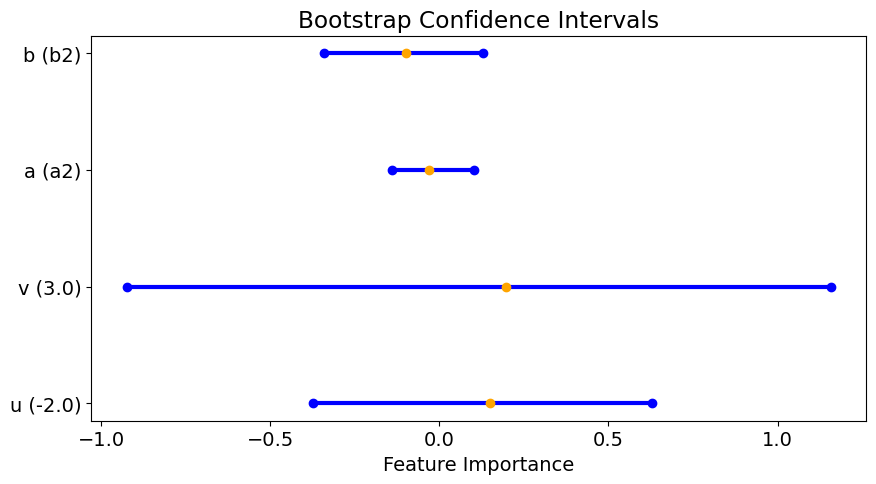

True gradient / differences:      
[[-0.03753613444026915], [0.005509045315418848], [0.061558805119857715, 0.043920383359322704], [0.05679293257528262, 0.0022966378075797433]]

Estimated gradient / differences: 
[[0.14867367781334906], [0.1963454288045341], [-0.030610144630266234, 0.07341696209402926], [-0.09819594821430755, -0.023157981353495616]]


In [6]:
true_grad = bte.get_gradient(ground_truth, query)
explanation = bte.explain_instance(query, m=m, k=k, verbose=True, with_confidence=True, boot_method='percentile', boot_ratio=boot_ratio, num_bootstrap=num_bootstrap, conf_level=0.95)
est_grad = bte.get_point_estimate(query, m=m, k=k) # point estimate

print(f"True gradient / differences:      \n{true_grad}")
print(f"\nEstimated gradient / differences: \n{est_grad}")

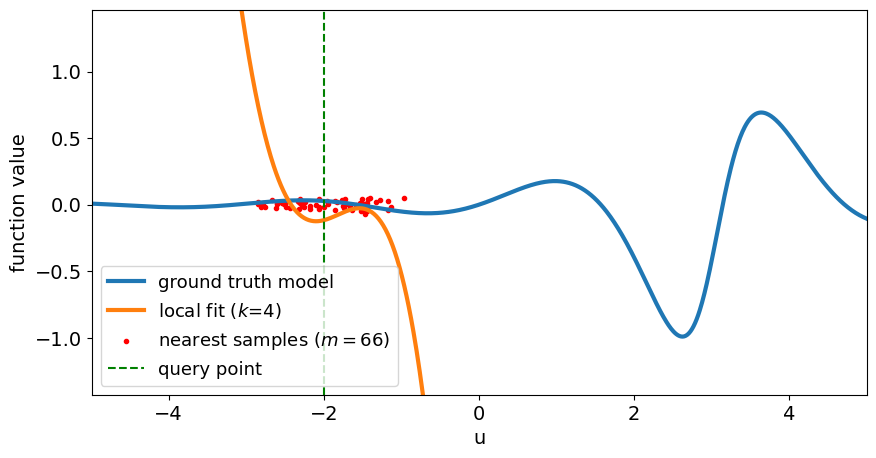

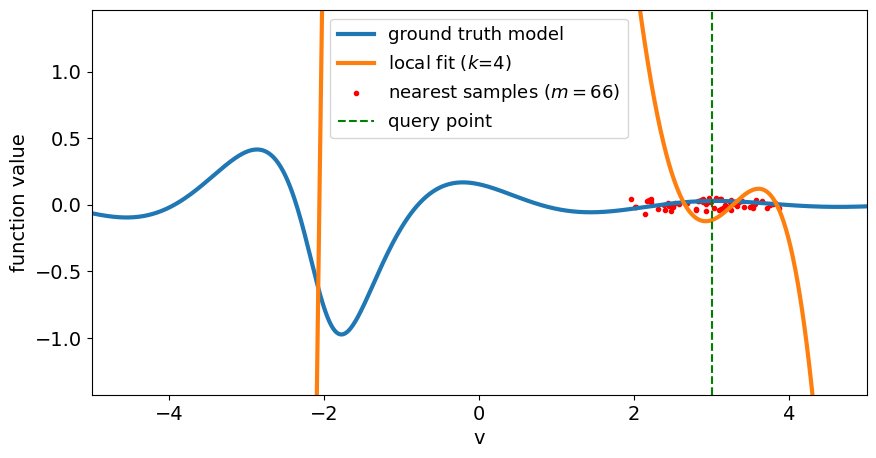

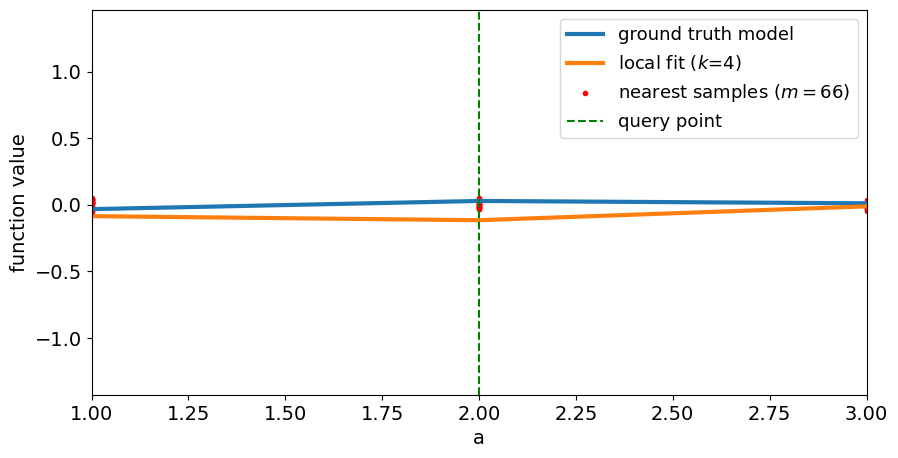

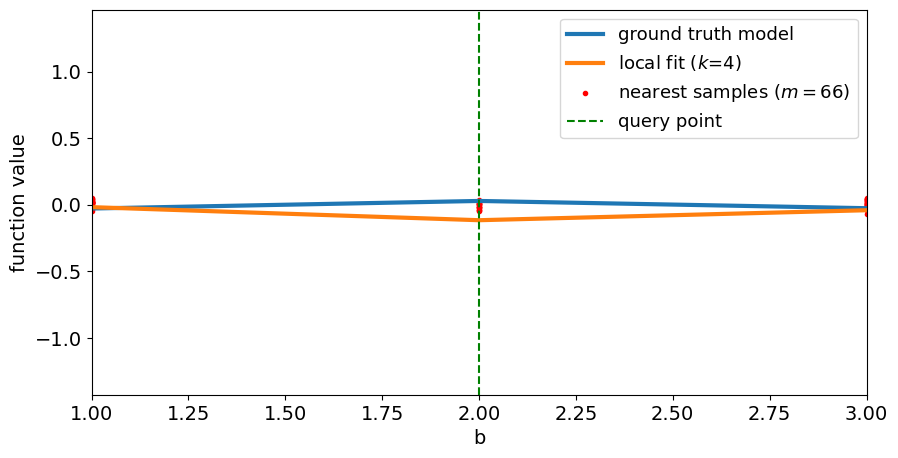

In [7]:
# Plot local polynomial model
for feature in range(4):
    if feature in [0,1]:
        plot_slice(ground_truth, lims=[np.min(X[:,feature]), np.max(X[:,feature])], const_values=query, dim=feature)
        bte.plot_local_slice(feature)
    else:
        plot_slice(ground_truth, lims=[np.min(X[:,feature]), np.max(X[:,feature])], const_values=query, dim=feature, feat_type='categorical')
        bte.plot_local_slice(feature)
    bte.plot_neighbors(feature)
    plt.vlines(query[feature], np.min(y), np.max(y), colors=["green"], linestyles='dashed')
    plt.ylim(np.min(y), np.max(y))
    plt.legend(["ground truth model", "local fit ($k$={})".format(k), "nearest samples ($m=${})".format(m), "query point"])
    plt.show()

## Theoretical confidence interval example

In [8]:
theoretical_results = bte.theoretical_CI(query, num_neighbors=m, k=k)
for d in range(bte.num_features):
    print("Feature: ", bte.feature_names[d])
    theo = theoretical_results[d]
    truth = true_grad[d]
    for i in range(len(truth)): 
        print(f"    True derivative / diff:                {truth[i]}")
        print(f"    Point estimate:                        {theo[0][i]}")
        print(f"    Bootstrap confidence interval:         [{theo[1][i]}, {theo[2][i]}]\n")

Feature:  u
    True derivative / diff:                -0.03753613444026915
    Point estimate:                        0.14867367781334906
    Bootstrap confidence interval:         [0.006174347182233475, 0.29117300844446464]

Feature:  v
    True derivative / diff:                0.005509045315418848
    Point estimate:                        0.1963454288045341
    Bootstrap confidence interval:         [-0.16510558415123205, 0.5577964417603003]

Feature:  a
    True derivative / diff:                0.061558805119857715
    Point estimate:                        -0.030610144630266234
    Bootstrap confidence interval:         [-0.07568520654042474, 0.014464917279892263]

    True derivative / diff:                0.043920383359322704
    Point estimate:                        0.07341696209402926
    Bootstrap confidence interval:         [0.01912465999645089, 0.12770926419160764]

Feature:  b
    True derivative / diff:                0.05679293257528262
    Point estimate:          

## Visual comparison of theoretical & bootstrap confidence intervals

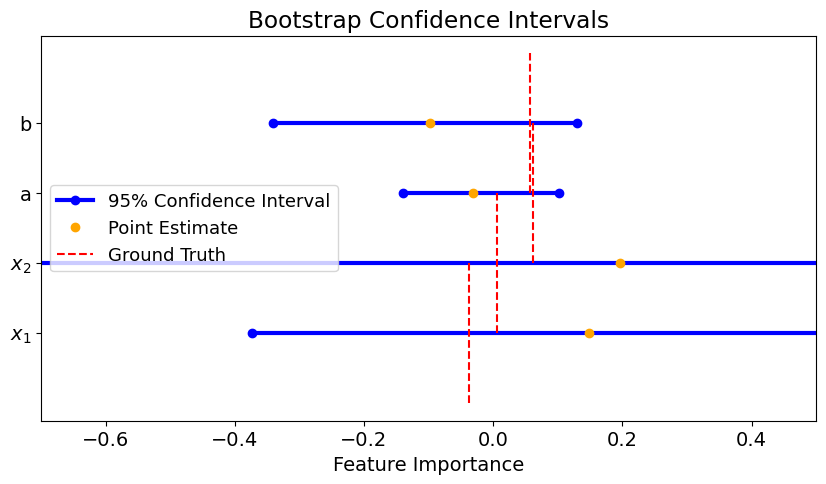

In [9]:
data_dict = {}
data_dict['category'] = ["$x_1$", "$x_2$", "a", "b"]
data_dict['lower'] = [explanation[d]['lower_confidence'] for d in range(num_features)]
data_dict['estimate'] = [explanation[d]['importance'] for d in range(num_features)]
data_dict['upper'] = [explanation[d]['upper_confidence'] for d in range(num_features)]
dataset = pd.DataFrame(data_dict)

count = 0
for lower,estimate,upper,y in zip(dataset['lower'],dataset['estimate'],dataset['upper'],range(len(dataset))):
    if count == 0:
        plt.plot((lower,upper),(y,y),'o-', color='blue', linewidth=3, label='95% Confidence Interval')
        plt.plot(estimate, y, 'o', color='orange', label='Point Estimate')
        count += 1
    else: 
        plt.plot((lower,upper),(y,y),'o-', color='blue', linewidth=3)
        plt.plot(estimate, y, 'o', color='orange')
plt.vlines(true_grad[0][0], -1, 1, colors=["red"], linestyles='dashed', label='Ground Truth')
plt.vlines(true_grad[1][0], 0, 2, colors=["red"], linestyles='dashed')
plt.vlines(true_grad[2][0], 1, 3, colors=["red"], linestyles='dashed')
plt.vlines(true_grad[3][0], 2, 4, colors=["red"], linestyles='dashed')
plt.yticks(range(len(dataset)),list(dataset['category']))
plt.xlabel('Feature Importance')
plt.title('Bootstrap Confidence Intervals')
plt.xlim([-0.7, 0.5])
plt.legend()
plt.show()

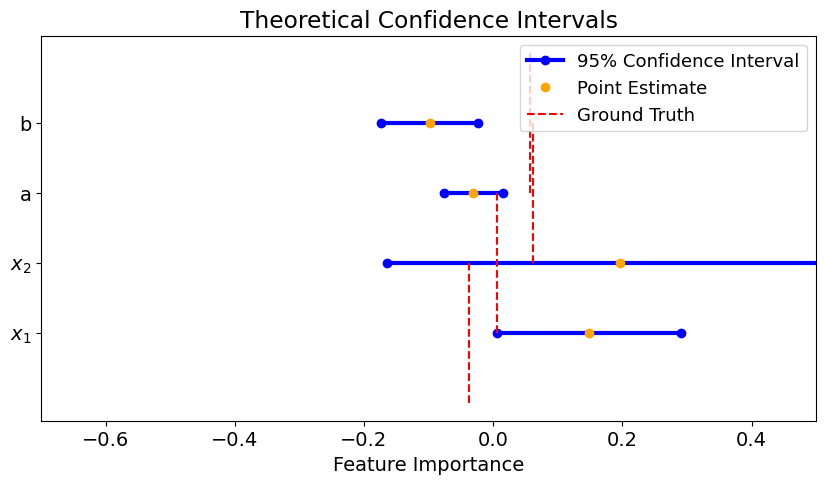

In [10]:
data_dict = {}
data_dict['category'] = ["$x_1$", "$x_2$", "a", "b"]
data_dict['lower'] = [theoretical_results[d][1][0] for d in range(num_features)]
data_dict['estimate'] = [theoretical_results[d][0][0] for d in range(num_features)]
data_dict['upper'] = [theoretical_results[d][2][0] for d in range(num_features)]
dataset = pd.DataFrame(data_dict)

count = 0
for lower,estimate,upper,y in zip(dataset['lower'],dataset['estimate'],dataset['upper'],range(len(dataset))):
    if count == 0:
        plt.plot((lower,upper),(y,y),'o-', color='blue', linewidth=3, label='95% Confidence Interval')
        plt.plot(estimate, y, 'o', color='orange', label='Point Estimate')
        count += 1
    else: 
        plt.plot((lower,upper),(y,y),'o-', color='blue', linewidth=3)
        plt.plot(estimate, y, 'o', color='orange')
plt.vlines(true_grad[0][0], -1, 1, colors=["red"], linestyles='dashed', label='Ground Truth')
plt.vlines(true_grad[1][0], 0, 2, colors=["red"], linestyles='dashed')
plt.vlines(true_grad[2][0], 1, 3, colors=["red"], linestyles='dashed')
plt.vlines(true_grad[3][0], 2, 4, colors=["red"], linestyles='dashed')
plt.yticks(range(len(dataset)),list(dataset['category']))
plt.xlabel('Feature Importance')
plt.title('Theoretical Confidence Intervals')
plt.xlim([-0.7, 0.5])
plt.legend()
plt.show()